In [14]:
#sncosmo.mcmc_lc
import sncosmo
import sfdmap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import astropy
from astropy.table import Table
from astropy import constants
import requests
import seaborn as sns
import json
from pydantic import BaseModel
from typing import Literal, List, Dict
import math
from sklearn.metrics import mean_squared_error

import time
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sncosmo.fitting import DataQualityError


snadoid_to_tbound = {
    228 : [58300, 58350],
    116 : [58330, 58360],
    135 : [58300, 58350],
    157 : [58290, 58340],
    229 : [58230, 58280],
    211 : [58625, 58675],
    238 : [58300, 58350],
}

class Observation(BaseModel):
    mjd: float
    flux: float
    fluxerr: float
    zp: float = 8.9
    zpsys: Literal['ab', 'vega'] = 'ab'
    band: str
    
class Target(BaseModel):
    light_curve: List[Observation]
    ebv: float
    t_min: float
    t_max: float
    count: int
    name_model: str 
    redshift: List[float]
    
class Point(BaseModel):
    time: float
    flux: float
    band: str

class Result(BaseModel):
    flux_jansky: List[Point]
    degrees_of_freedom: int
    covariance: List[List[float]]
    mse:float
    parameters: Dict[str, float]
    
    
def fit(data, name_model, ebv, redshift, snadid):
    dust = sncosmo.CCM89Dust()
    model = sncosmo.Model(source=name_model, effects=[dust], effect_names=['mw'], effect_frames=['obs'])
    model.set(mwebv=ebv)
    snadid = int(snadid[4:])
    try: 
        if snadid in snadoid_to_tbound.keys():
            print(snadid)
            res = sncosmo.nest_lc(
                data, model, ['z', 't0', 'amplitude'], #guess_z=True,
                                                   bounds={'z':(redshift[0], redshift[1]), 
                                                           't0':(snadoid_to_tbound[snadid][0], snadoid_to_tbound[snadid][1])})
                                    
        else:
            res = sncosmo.nest_lc(data, model, ['z', 't0', 'amplitude'], #guess_z=True, 
                                                   bounds={'z':(redshift[0], redshift[1])}
                                                  )
        #print(type(res[0]))
        
    except DataQualityError as d: 
        print('DataQualityError')
        df = pd.DataFrame({'name' : snadid, 'model' : name_model, 'error' : 'DataQualityError', 'text' : str(d)})
        df.to_csv('id_exception_v24.csv', mode='a', index= False, header=False)
        return {'error' : 'DataQualityError'}
    except RuntimeError as r: 
        print('RuntimeError')
        df = pd.DataFrame([{'name' : snadid, 'model' : name_model, 'error' : 'RuntimeError', 'text' : str(r)}])
        df.to_csv('id_exception_v24.csv', mode='a', index= False, header=False)
        return {'error' : 'RuntimeError'}
    return res


def get_flux_and_params(summary, data, fitted_model, t_min, t_max, count):

    segment = np.linspace(t_min, t_max, count)
    df = data.to_pandas()
    points = []
    mse = 0
    for band in df['band'].unique():
        predicts = fitted_model.bandflux(band, segment, df['zp'][0], df['zpsys'][0])
        points += [Point(time=time, flux=flux, band=band) for time, flux in zip(segment, predicts)]
        df['predicts'] = fitted_model.bandflux(band, sorted(df['mjd']), df['zp'][0], df['zpsys'][0])
        mse += mean_squared_error(df['flux'], df['predicts'])
    try: cov=summary.covariance.tolist() 
    except: 
        cov=[[]] 
        print('covariance is none')
    
    return Result(flux_jansky=points, parameters=dict(zip(summary.param_names, summary.parameters)), 
                       degrees_of_freedom=summary.ndof, covariance=cov, mse=mse)


def approximate(data: Target, snadid):

    df = pd.DataFrame([obs.model_dump() for obs in data.light_curve])
    table = Table.from_pandas(df)
    fit_data = fit(table, data.name_model, data.ebv, data.redshift, snadid)
    try: summary, fitted_model = fit_data
    except ValueError: return fit_data
    result = get_flux_and_params(summary, table, fitted_model, data.t_min, data.t_max, data.count)
    return result


oid_to_tmax = { # время максимума только для графика, фит строится
    169 : 58572.42763, 204 : 58605.40540, 241 : 58231.36666, 211 : 58647.32578, 238 : 58324.20177, 186 : 58198.38628,
    234 : 58224.44818, 152 : 58222.30126, 110 : 58269.19916, #228 : 58326
}


def plot(curves: Result, data, oid_namemodel, t_l, t_r):
    band_color = {'ztfr' : 'r', 'ztfg' : 'g', 'ztfi' : 'm'}
    mjd_offset = 58000
    data_r = data[data['band']=='ztfr']
    data_g = data[data['band']=='ztfg']
    if data_r.shape[0]>data_g.shape[0]:
        data_max = data_r
    else: data_max = data_g
    #key = int(oid_namemodel[4:7])
    #if key in oid_to_tmax.keys(): t_max_mag = oid_to_tmax[key] - mjd_offset
    #else: t_max_mag = data_max[data_max['mag']==data_max['mag'].min()]['mjd'].values[0] - mjd_offset
    t_l -= mjd_offset
    t_r -= mjd_offset
    data = data[((data['mjd'] - mjd_offset >= t_l) & (data['mjd'] - mjd_offset <= t_r))]
    print('Uniq band', data['band'].unique())
    curve = pd.DataFrame([obs.model_dump() for obs in curves.flux_jansky])
    fig, axs = plt.subplots(1, len(data['band'].unique()), figsize=(16,5))
    axs = np.array(axs)
    plt.suptitle(oid_namemodel, fontsize=20)
    it = 0
    for it, ax_band in enumerate(zip(axs.reshape(-1), sorted(data['band'].unique(), 
                                                             key = lambda x: 1 if x[-1]=='g' else (2 if x[-1]=='r' else 3)))):
        ax, band = ax_band[0], ax_band[1]
        data_band = data[data['band']==band]
        curve_band = curve[curve['band']==band]
        flux_max = max(data['flux'].max(), curve_band['flux'].max())
        flux_min = min(data['flux'].min(), curve_band['flux'].min())
        ax.set_xlim([t_l, t_r])
        ax.set_ylim([-5+flux_min*10**6, flux_max*10**6+10])
        ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)
        ax.plot(curve_band['time']-mjd_offset, curve_band['flux'] * 10**6, color=band_color[band])
        ax.set_xlabel("MJD-58000", fontsize=16)
        ax.grid(which='major')
        matplotlib.rc('xtick', labelsize=15)
        ax.legend(prop={"size":16})
        if it==0: 
            ax.set_ylabel("Flux, " + "μ" + "Jy", fontsize=16)
            matplotlib.rc('ytick', labelsize=15)
        #plt.savefig('Lom/' + oid_namemodel)
    plt.show()
        

def task(oid, list_models, count, redshift):
    data = pd.read_csv('data_calc_ref/' + str(oid) + '.csv')
    snadid = data['Name'][0]
    oid_ebv = pd.read_csv('oid_ebv.csv')
    ebv = float(list(oid_ebv[oid_ebv['OID'] == oid]['ebv'])[0])
    data_r = data[data['band']=='ztfr']
    data_g = data[data['band']=='ztfg']
    if data_r.shape[0]>data_g.shape[0]:
        data_max = data_r
    else: data_max = data_g
    #t_max_mag = data_max[data_max['mag']==data_max['mag'].min()]['mjd'].values[0]
    #try: t_max_mag = oid_to_tmax_plot[int(snadid[4:7])] 
    #except KeyError: t_max_mag = data_max[data_max['mag']==data_max['mag'].min()]['mjd'].values[0] 
    #t_min = t_max_mag - 30
    #t_max = t_max_mag + 120
    key = int(snadid[4:7])
    if key in oid_to_tmax.keys(): t_max_mag = oid_to_tmax[key] #- mjd_offset
    else: t_max_mag = data_max[data_max['mag']==data_max['mag'].min()]['mjd'].values[0] #- mjd_offset
    max_mag = data_max['mag'][data['mjd']==t_max_mag].values[0]
    print(max_mag)
    if max_mag>=21:
        redshift = [0.035,0.65] # [-15,-22] for 21 mag
    elif max_mag>=20:
        redshift = [0.025,0.45] # [-15,-22] for 20 mag
    elif max_mag>=19:
        redshift = [0.015,0.30] # [-15,-22] for 19 mag
    #redshift = [0.01,0.65]
    print(redshift)
    t_l = t_max_mag - 30
    t_r = t_max_mag + 120
    #data = data[data['band']=='ztfr']
    data['zp'] = 8.9
    data['zpsys'] = 'ab'
    data.drop(['Unnamed: 0', 'magerr', 'clrcoeff', 'oid', 'flux', 'fluxerr', 'ref', 'referr', 'Name'], axis= 1 , inplace= True)
    data = data.rename(columns={'flux_dif': 'flux', 'flux_dif_err': 'fluxerr'})
    data.dropna()
    json_flux_dif = data.to_dict('records')
    result_list = []
    for model in list_models:
        curves = approximate(Target(light_curve=[Observation(mjd=obs['mjd'], flux=obs['flux'], fluxerr=obs['fluxerr'], 
                                                             band=obs['band'], zp=obs['zp'], zpsys=obs['zpsys']) 
                                          for obs in json_flux_dif], ebv=ebv, name_model=model, t_min=t_l, t_max=t_r, 
                                    count=count, redshift=redshift), snadid)        
        try: plot(curves, data, str(snadid)+'_'+model, t_l, t_r)
        except AttributeError:
            res = -1
        try: 
            z = curves.parameters['z']
            m_abs_max = data_r['mag'].min() - astropy.cosmology.Planck18.distmod(z).value
            res = {'name' : snadid, 'model' : model, 'M' : m_abs_max, 'mse' : curves.mse, 'z' : z,
                    't0' : curves.parameters['t0'], 'amplitude' : curves.parameters['amplitude'], 'mwebv' : curves.parameters['mwebv'],
                    'mwr_v' : curves.parameters['mwr_v'], 'max_mag' : max_mag}
        except AttributeError:
            print(res, 'AttributeError')
            res = -1
        if type(res) is dict:
            result_list.append(res)
    result_list.sort(key=lambda x: x['mse'])
    df_result = pd.DataFrame(result_list)
    print(df_result)
    #df_result.to_csv('id_result_z_v15.csv', mode='a', index= False, header=False)
    return result_list


def get_best_fit(oid, list_models, t_min, t_max, count, redshift):
    result_list = []
    for model in list_models:
        res = task(oid, model, t_min, t_max, count, redshift)
        if type(res) is dict: result_list.append(res)
    result_list.sort(key=lambda x: x['chi2'])
    print(result_list)
    
    
#list_nugent = ['nugent-sn1a', 'nugent-sn91t', 'nugent-sn91bg', 'nugent-sn1bc', 'nugent-hyper', 'nugent-sn2n', 'nugent-sn2l', 'nugent-sn2p']
list_nugent = ['nugent-sn1a', 'nugent-sn1bc', 'nugent-sn2n', 'nugent-sn2l', 'nugent-sn2p']

       Name       R.A.      Dec.              OID  Discovery date (UT)    mag  \
7   SNAD108  257.84004  48.21127  762209400037712  2018-04-16 10:34:47  21.23   
10  SNAD111  263.42634  52.62203  796201100002136  2018-06-21 07:59:02  21.32   
11  SNAD112  263.37725  51.25848  796201400007564  2018-05-14 09:19:47  20.98   

    er_down  er_up    ref  er_ref         TNS Type      Comments  
7      0.28   0.38  20.99    0.06  AT 2018lwo  PSN  ZTF18abauopo  
10     0.28   0.39  21.72    0.15  AT 2018lwr  PSN  ZTF18abdldos  
11     0.22   0.28  22.63    0.26  AT 2018lws  PSN  ZTF18aaubejv  
19.091373
[0.015, 0.3]
Uniq band ['ztfr' 'ztfg']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


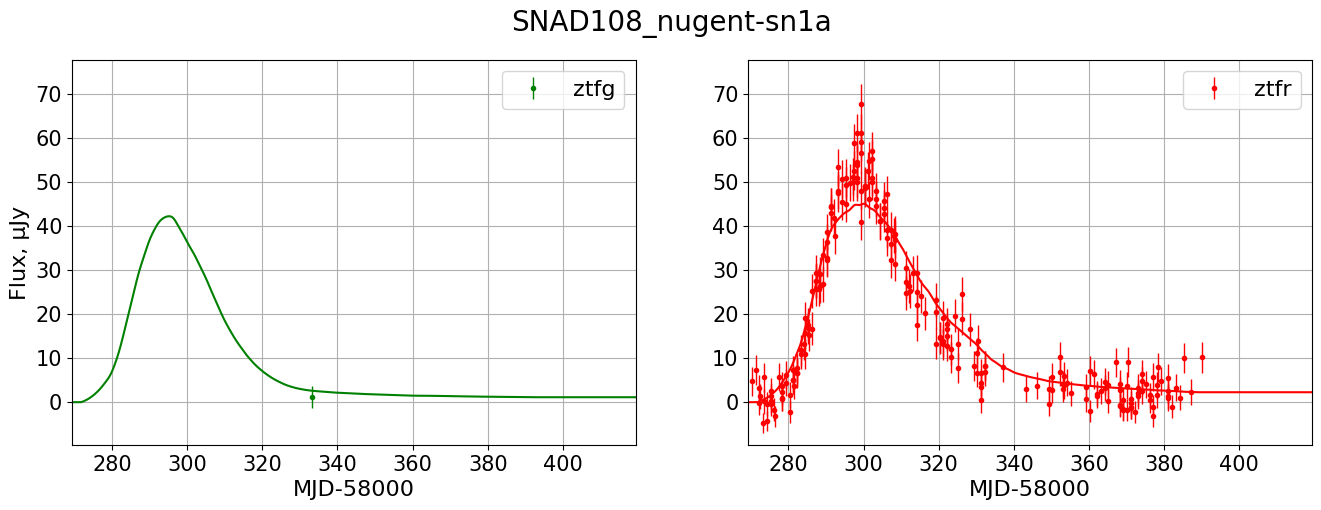

Uniq band ['ztfr' 'ztfg']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


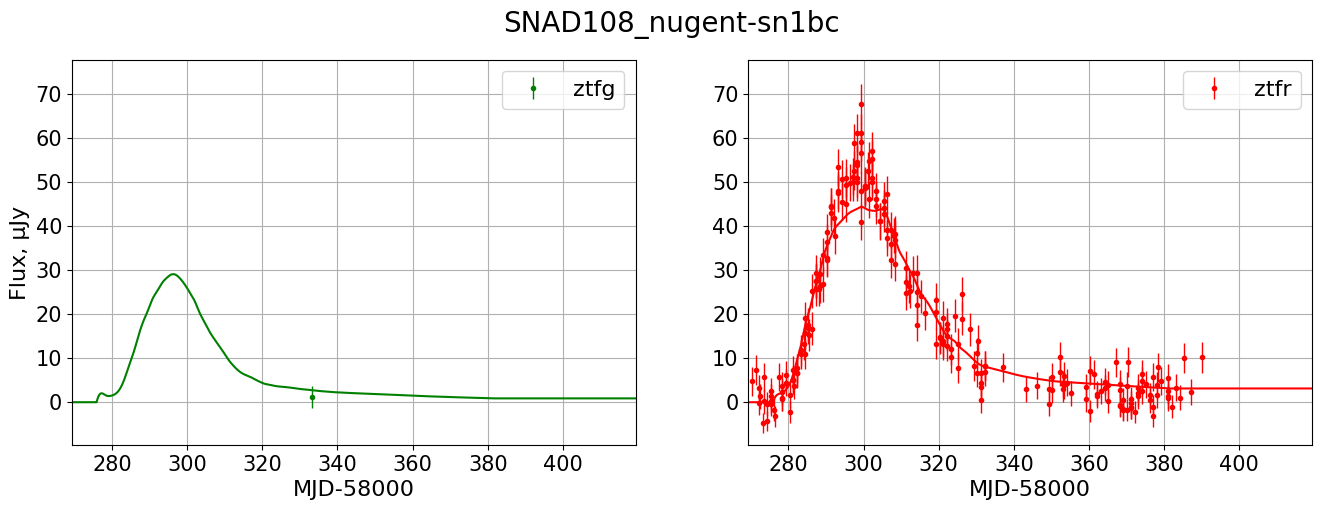

Uniq band ['ztfr' 'ztfg']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


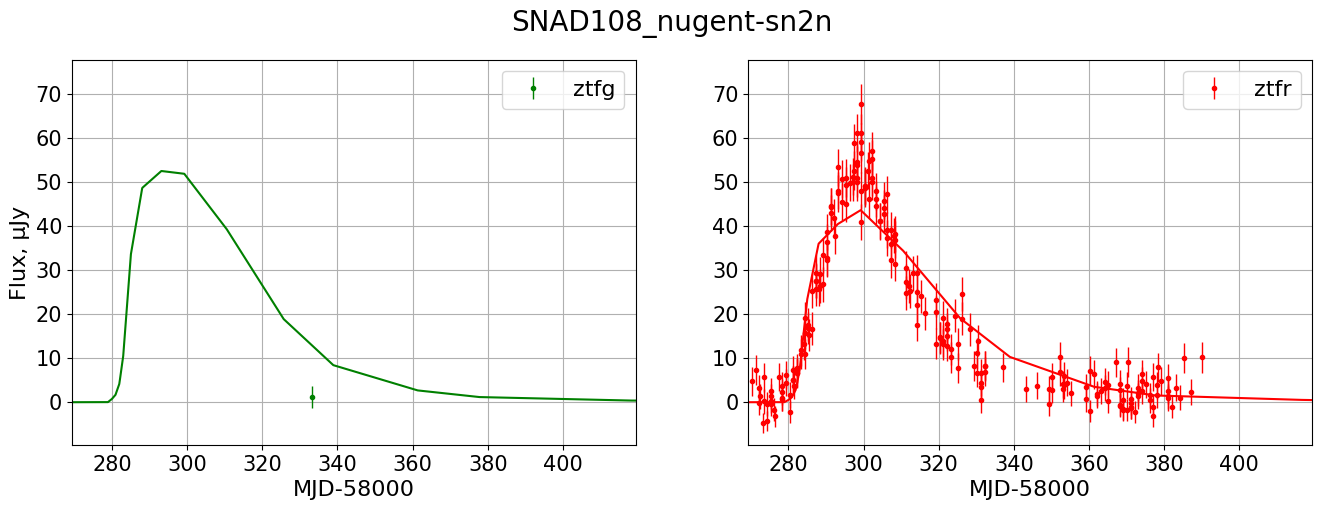

Uniq band ['ztfr' 'ztfg']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


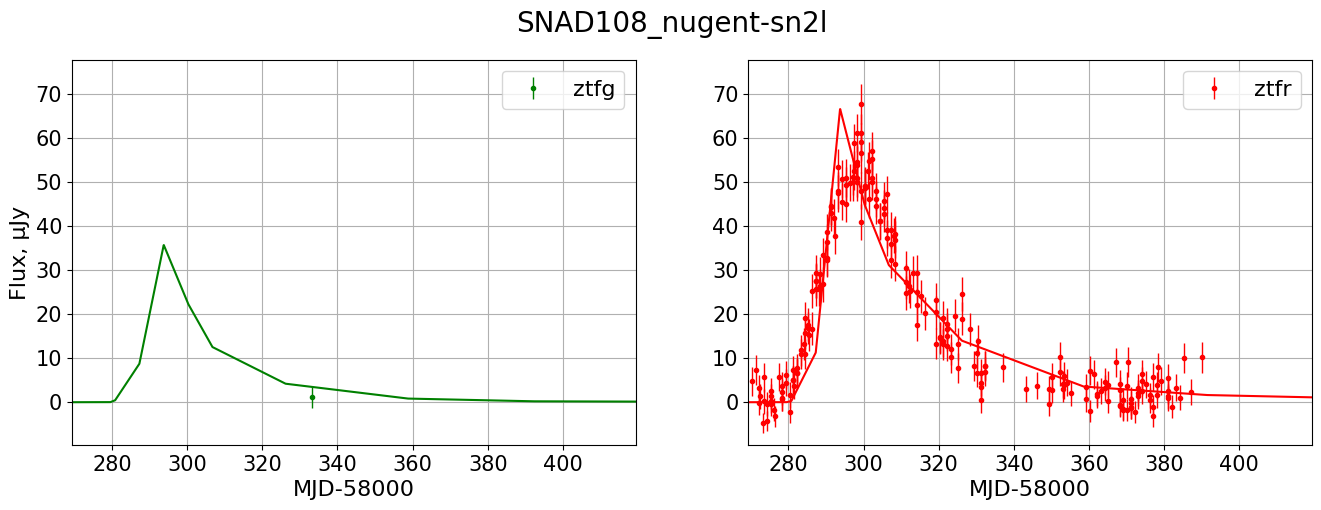

Uniq band ['ztfr' 'ztfg']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


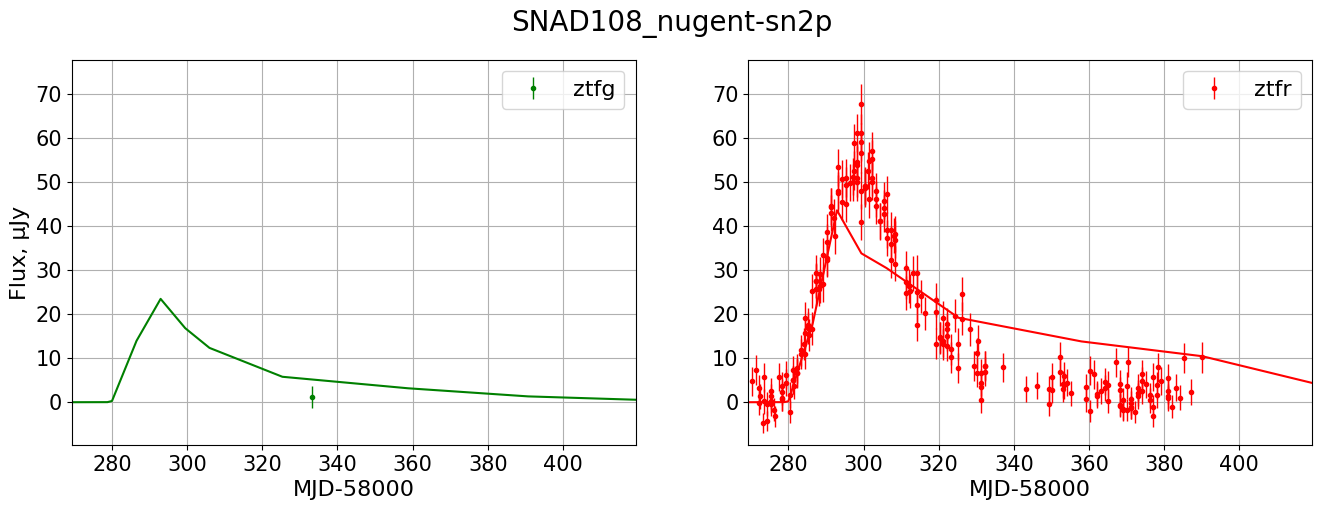

      name         model          M           mse         z            t0  \
0  SNAD108   nugent-sn1a -21.877888  1.076989e-10  0.293495  58271.781843   
1  SNAD108   nugent-sn2n -15.274296  1.287578e-10  0.016641  58278.897725   
2  SNAD108  nugent-sn1bc -21.421763  1.506582e-10  0.244137  58275.904064   
3  SNAD108   nugent-sn2l -21.893868  1.601413e-10  0.295380  58279.516440   
4  SNAD108   nugent-sn2p -21.879259  2.050890e-10  0.293656  58278.702018   

      amplitude  mwebv  mwr_v    max_mag  
0  1.005682e-08   0.01    3.1  19.091373  
1  1.359223e-08   0.01    3.1  19.091373  
2  1.181719e-08   0.01    3.1  19.091373  
3  1.435717e-08   0.01    3.1  19.091373  
4  9.403652e-09   0.01    3.1  19.091373  
19.77927
[0.015, 0.3]
Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


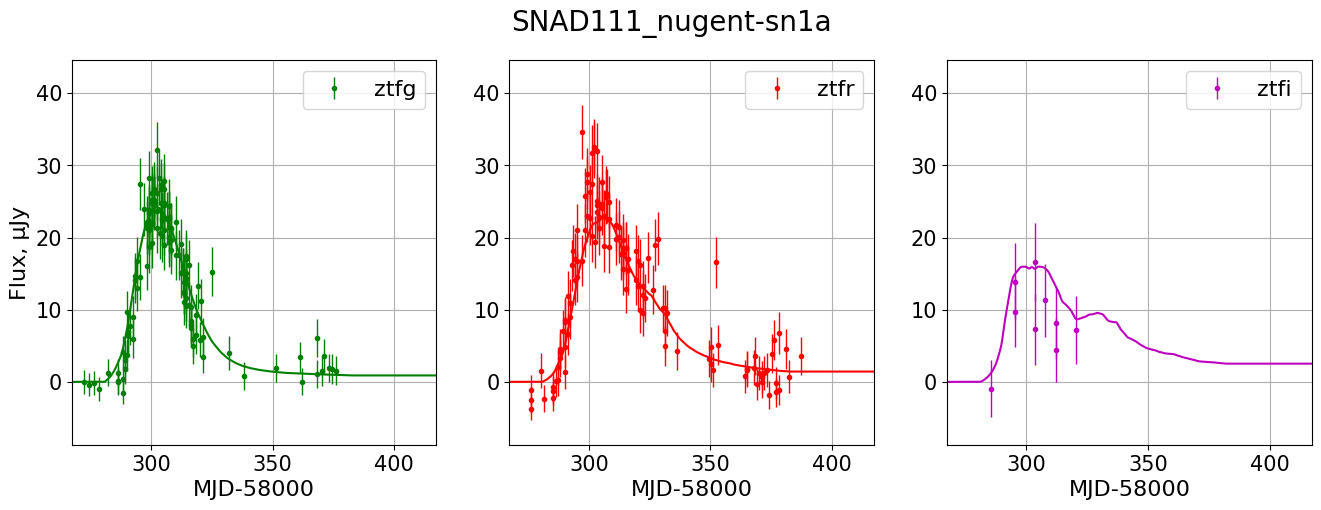

Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


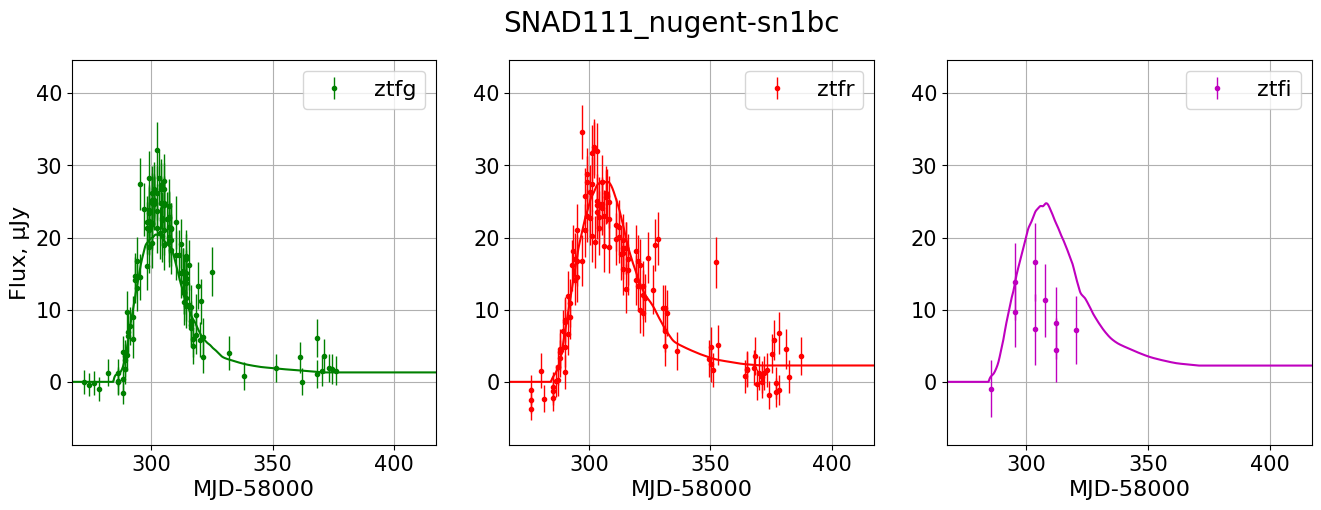

Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


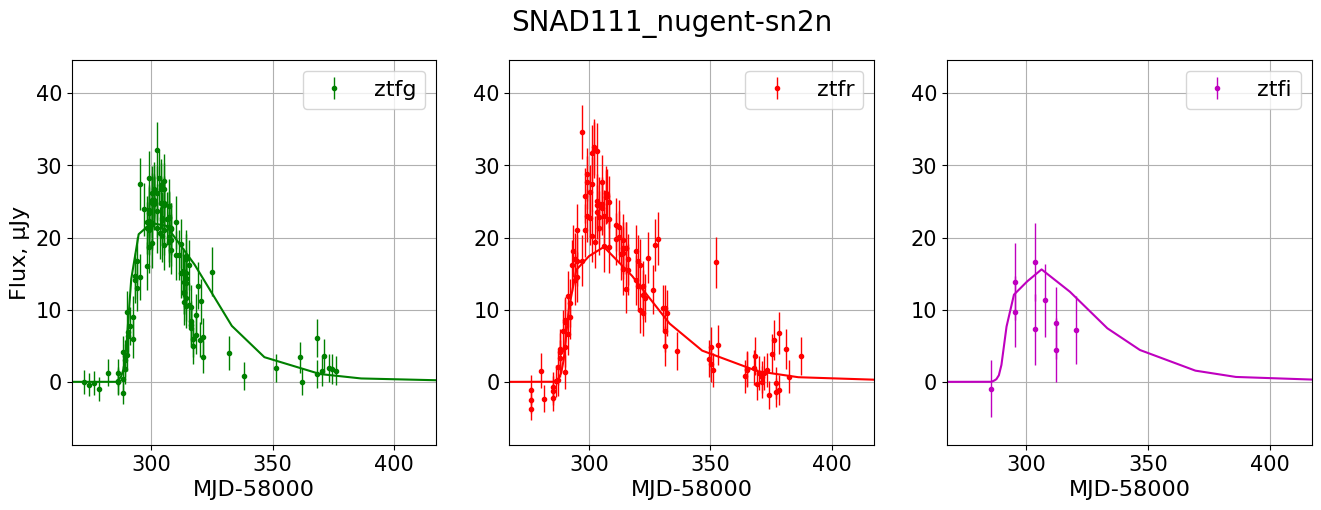

Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


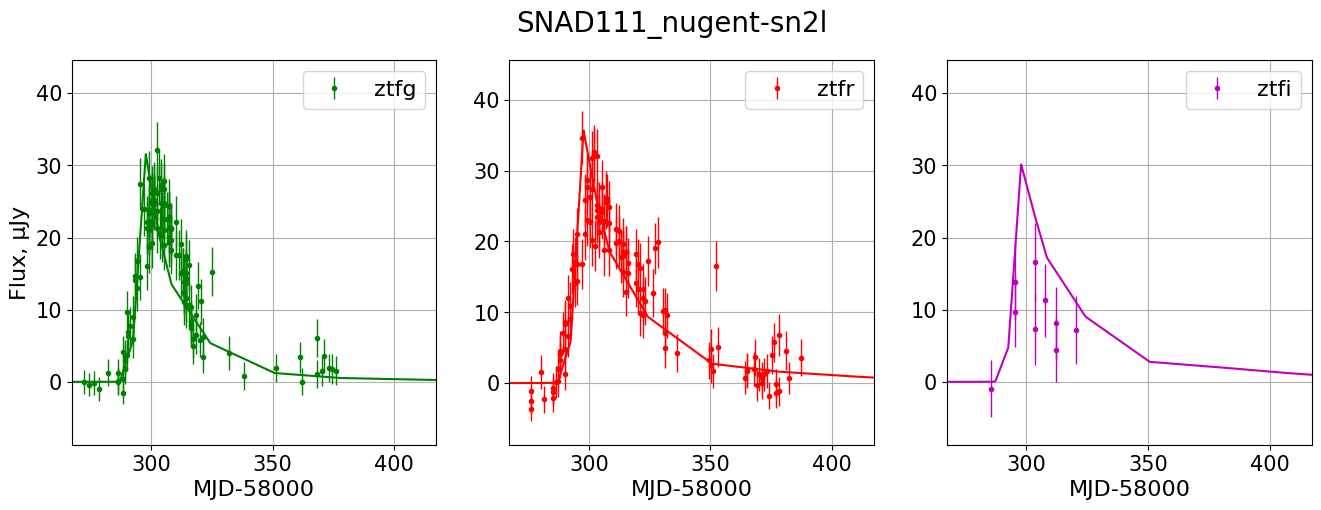

Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


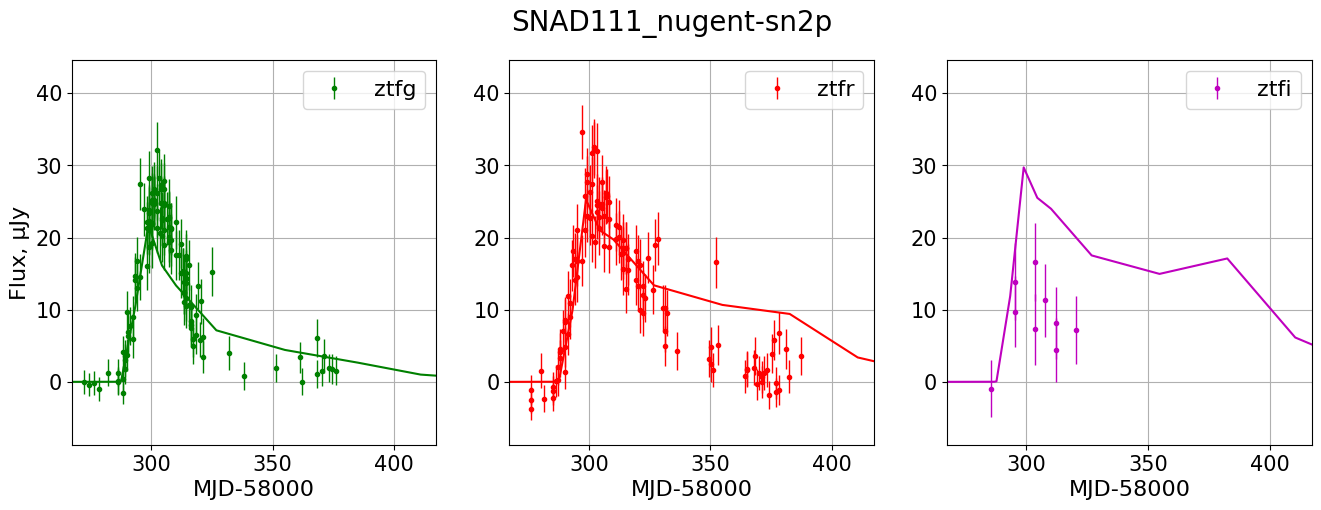

      name         model          M           mse         z            t0  \
0  SNAD111   nugent-sn1a -19.077918  4.415290e-10  0.122366  58280.909588   
1  SNAD111   nugent-sn2n -16.144312  4.778950e-10  0.033674  58285.544162   
2  SNAD111  nugent-sn1bc -14.586907  4.795252e-10  0.016645  58284.428347   
3  SNAD111   nugent-sn2l -17.332028  5.977774e-10  0.057215  58286.184472   
4  SNAD111   nugent-sn2p -18.965300  6.021234e-10  0.116613  58286.549990   

      amplitude  mwebv  mwr_v   max_mag  
0  6.276827e-09   0.03    3.1  19.77927  
1  5.929011e-09   0.03    3.1  19.77927  
2  8.012661e-09   0.03    3.1  19.77927  
3  9.548566e-09   0.03    3.1  19.77927  
4  6.983007e-09   0.03    3.1  19.77927  
19.256176
[0.015, 0.3]
Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


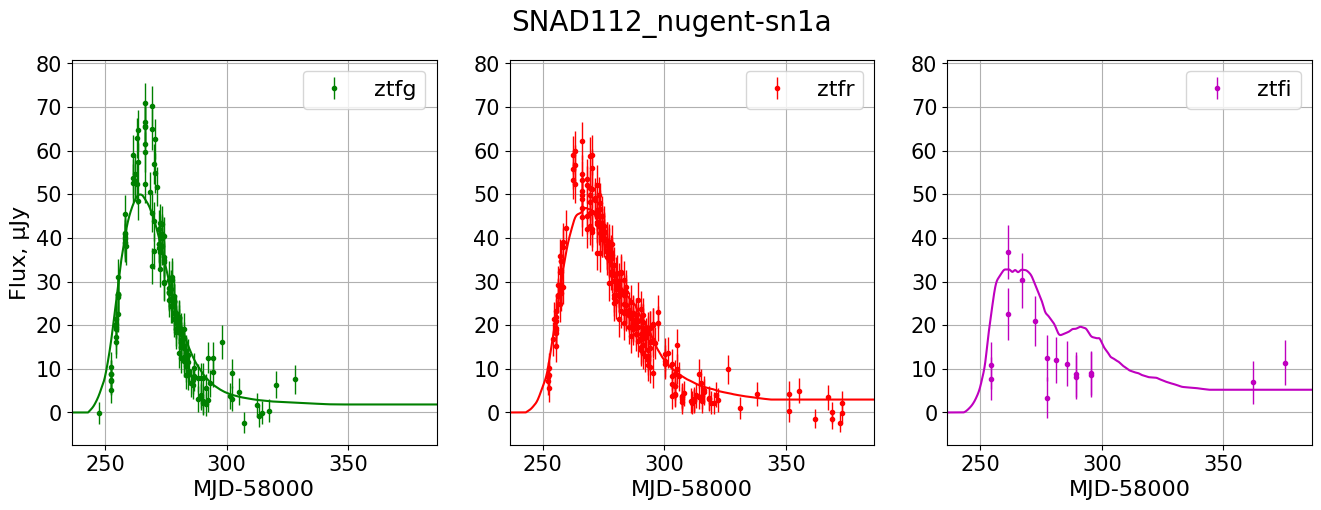

Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


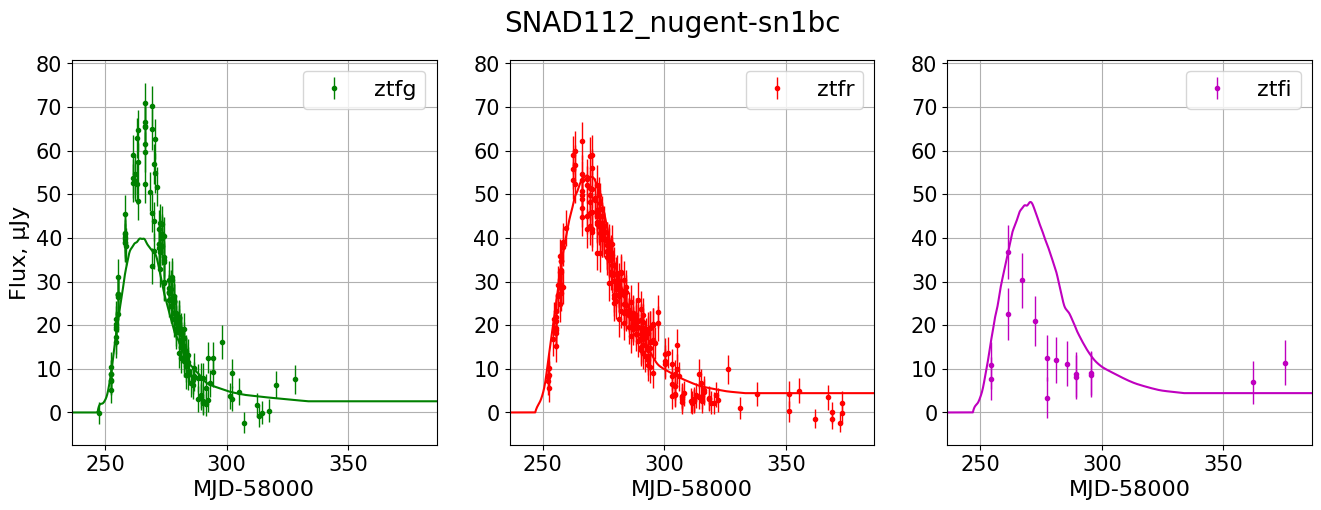

Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


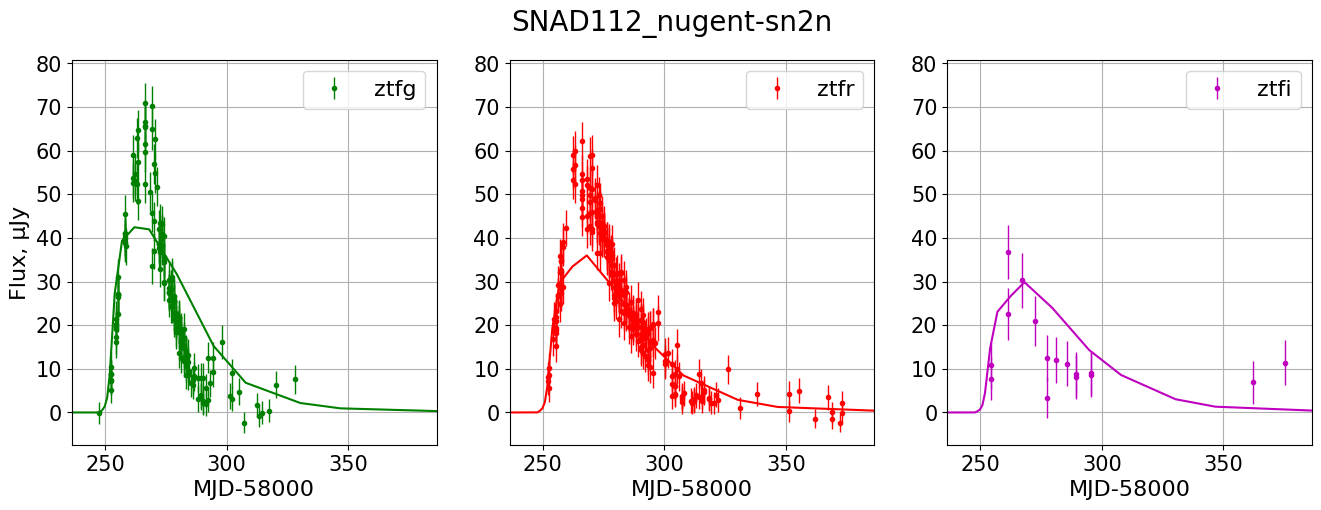

Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


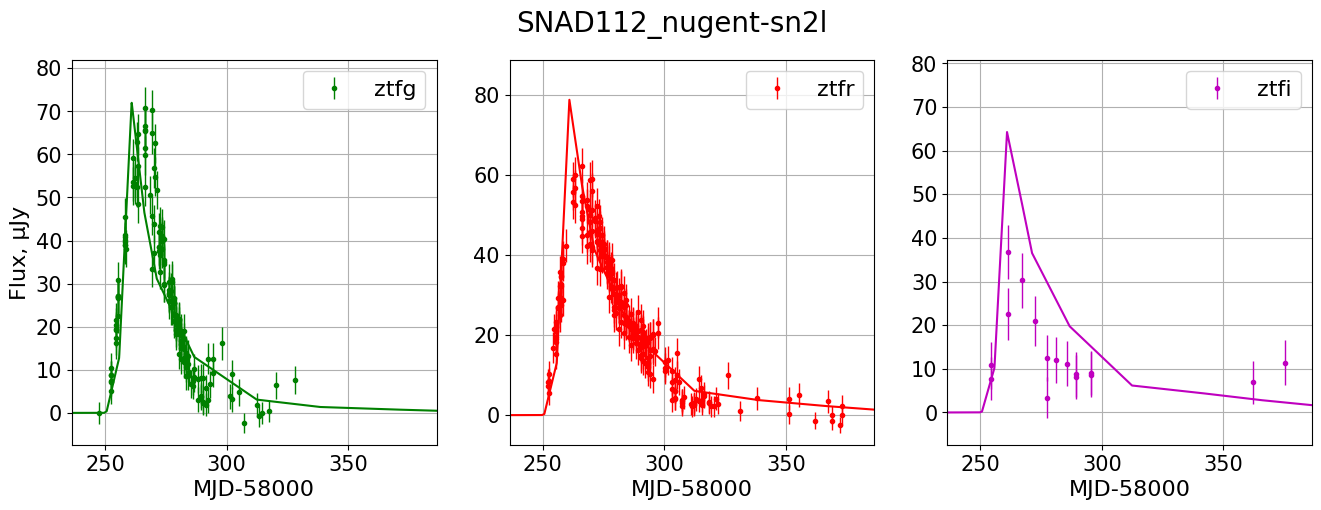

Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_3952/229750773.py:167: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


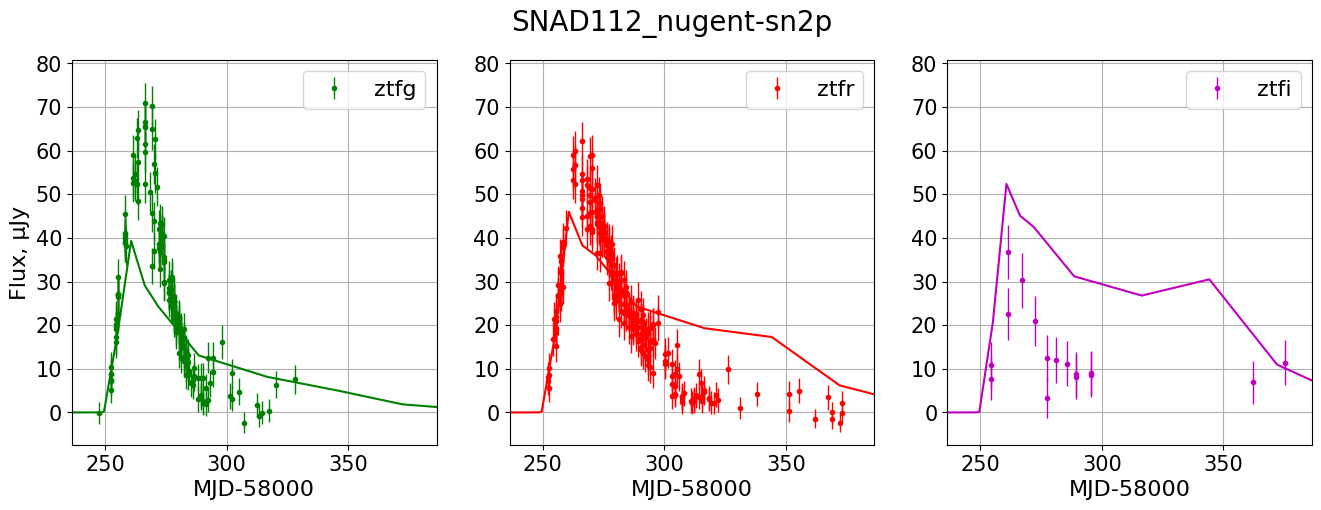

      name         model          M           mse         z            t0  \
0  SNAD112   nugent-sn2n -14.999969  1.005299e-09  0.015832  58247.825841   
1  SNAD112   nugent-sn1a -19.572398  1.103471e-09  0.120880  58243.027407   
2  SNAD112   nugent-sn2p -19.413005  1.116172e-09  0.112905  58248.462776   
3  SNAD112  nugent-sn1bc -14.935151  1.296330e-09  0.015372  58246.915309   
4  SNAD112   nugent-sn2l -16.259304  1.495764e-09  0.028020  58249.635946   

      amplitude  mwebv  mwr_v    max_mag  
0  1.177964e-08   0.03    3.1  19.256176  
1  1.297292e-08   0.03    3.1  19.256176  
2  1.258438e-08   0.03    3.1  19.256176  
3  1.563091e-08   0.03    3.1  19.256176  
4  2.177402e-08   0.03    3.1  19.256176  


In [9]:
objects = pd.read_csv('snad_catalog.csv')
objects = objects[objects['Type']=='PSN']
objects = pd.concat([objects[objects['Name'].apply(lambda x: int(x[4:]))==108], objects[objects['Name'].apply(lambda x: int(x[4:]))==111], 
    objects[objects['Name'].apply(lambda x: int(x[4:]))==112]])
print(objects)
for oid in objects['OID']:
    task(oid, list_nugent, 3000, [0.01, 0.65])

In [ ]:
objects = pd.read_csv('snad_catalog.csv')
objects = objects[objects['Type']=='PSN']
objects = objects[objects['Name'].apply(lambda x: int(x[4:]))>=101]
print(objects)
for oid in objects['OID']:
    task(oid, list_nugent, 3000, [0.01, 0.3])

        Name       R.A.      Dec.              OID  Discovery date (UT)  \
0    SNAD101  247.45543  24.77282  633207400004730  2018-04-08 09:45:49   
1    SNAD102  245.05375  28.38220  633216300024691  2018-03-21 11:08:19   
3    SNAD104  218.91620  46.38441  758205400019523  2018-06-24 07:23:27   
5    SNAD106  219.41935  50.16706  758213400002862  2018-05-04 07:48:50   
6    SNAD107  254.41703  44.29804  762202300014913  2018-05-04 07:39:44   
..       ...        ...       ...              ...                  ...   
139  SNAD240  250.78941  66.39883  847102300000383  2018-05-10 08:48:46   
140  SNAD241  240.77847  47.31124  761108100005391  2018-04-22 08:42:04   
141  SNAD242  171.50084  44.96460  753101100007466  2018-06-03 04:41:06   
142  SNAD243  113.91920  31.77959  662105400007673  2018-03-30 05:34:18   
143  SNAD244  250.59311  24.97684  633105300018089  2018-03-30 10:48:56   

       mag  er_down  er_up    ref  er_ref         TNS Type      Comments  
0    21.11     0.27   0.

In [40]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'model', 'M', 'chi2', 'z', 't0', 'amplitude', 'mwebv', 'mwr_v', 'max_mag'])
df.to_csv('result_z_v11.csv', mode='a', index= False)
results = pd.read_csv('id_result_z_v11.csv')
for obj in results['name'].unique():
    df_obj = results[results['name']==obj].sort_values(by='chi2')
    #df_obj.drop(['z', 't0', 'amplitude', 'mwebv', 'mwr_v'], axis= 1 , inplace= True)
    df_obj = df_obj.head(1)
    df_obj.to_csv('result_z_v11.csv', mode='a', index= False, header=False)

In [42]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'model', 'M', 'mse', 'z', 't0', 'amplitude', 'mwebv', 'mwr_v', 'max_mag'])
df.to_csv('result_z_v12.csv', mode='a', index= False)
results = pd.read_csv('id_result_z_v12.csv')
for obj in results['name'].unique():
    df_obj = results[results['name']==obj].sort_values(by='mse')
    #df_obj.drop(['z', 't0', 'amplitude', 'mwebv', 'mwr_v'], axis= 1 , inplace= True)
    df_obj = df_obj.head(1)
    df_obj.to_csv('result_z_v12.csv', mode='a', index= False, header=False)

       name         model          M          chi2         z            t0   
29  SNAD108   nugent-sn2p -21.928230  2.054913e-10  0.299471  58278.823174  \
41  SNAD111   nugent-sn2n -16.226085  4.793984e-10  0.034934  58285.535812   
45  SNAD112   nugent-sn2n -15.012879  1.005396e-09  0.015925  58247.840735   
48  SNAD112  nugent-sn1bc -14.962752  1.294415e-09  0.015566  58246.880758   
49  SNAD112   nugent-sn2l -16.794415  1.498912e-09  0.035651  58249.583427   

       amplitude  mwebv  mwr_v    max_mag  
29  9.393283e-09   0.01    3.1  19.091373  
41  5.943792e-09   0.03    3.1  19.779270  
45  1.176321e-08   0.03    3.1  19.256176  
48  1.561834e-08   0.03    3.1  19.256176  
49  2.164988e-08   0.03    3.1  19.256176  


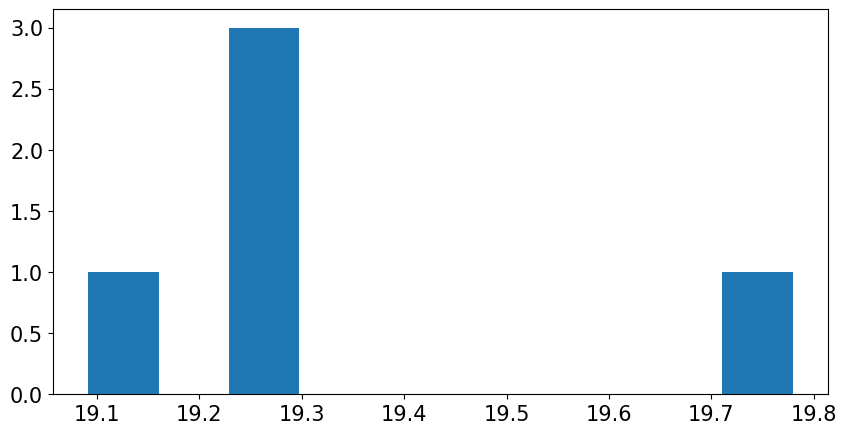

['SNAD108' 'SNAD111' 'SNAD112']


In [45]:
df = pd.read_csv('id_result_z_v11.csv')
df = df[(abs(df['z']-0.035)<0.001) | (abs(df['z']-0.65)<0.001)| (abs(df['z']-0.025)<0.001)| (abs(df['z']-0.45)<0.001) 
        | (abs(df['z']-0.015)<0.001) | (abs(df['z']-0.30)<0.001)]
#[0.035,0.65]
#[0.025,0.45] 
#[0.015,0.30] 
print(df)
fig, ax = plt.subplots(1, 1, figsize=(10,5)) 
ax.hist(df['max_mag'])
plt.show()
print(df['name'].unique())

        name         model          M           mse         z            t0   
1    SNAD101   nugent-sn1a -21.732170  8.148849e-10  0.299109  58337.683079  \
5    SNAD102   nugent-sn2n -16.180999  7.394753e-10  0.025001  58284.495719   
16   SNAD106   nugent-sn2n -15.337438  1.496190e-10  0.024577  58225.632112   
41   SNAD111   nugent-sn2n -16.216606  4.789325e-10  0.034786  58285.538627   
48   SNAD112  nugent-sn1bc -15.008094  1.293833e-09  0.015890  58246.945272   
55   SNAD114   nugent-sn2n -16.047778  1.551457e-09  0.024149  58252.860529   
59   SNAD114  nugent-sn1bc -15.021297  2.362839e-09  0.015154  58253.136189   
86   SNAD121   nugent-sn2p -16.461909  7.819552e-10  0.035963  58344.277864   
101  SNAD124   nugent-sn2n -15.792269  2.667202e-09  0.015335  58196.463967   
183  SNAD142   nugent-sn2p -16.392688  5.521984e-10  0.034596  58331.937830   
185  SNAD143  nugent-sn1bc -15.190409  1.229976e-09  0.015998  58191.120214   
197  SNAD145   nugent-sn2n -15.272895  1.261900e-10 

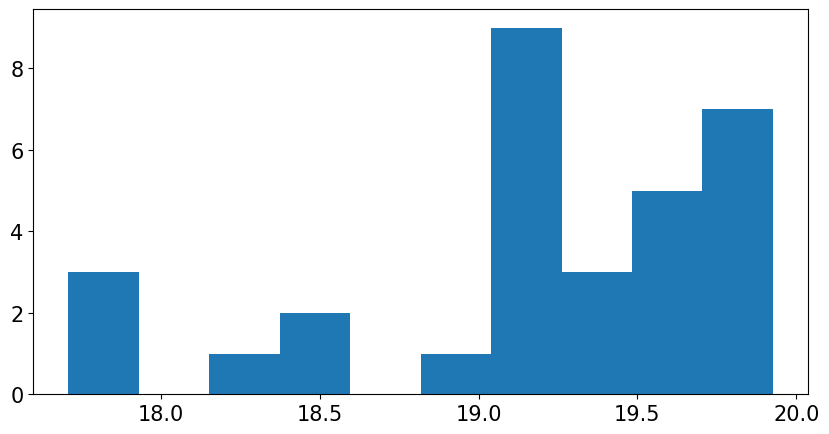

['SNAD101' 'SNAD102' 'SNAD106' 'SNAD111' 'SNAD112' 'SNAD114' 'SNAD121'
 'SNAD124' 'SNAD142' 'SNAD143' 'SNAD145' 'SNAD150' 'SNAD165' 'SNAD166'
 'SNAD167' 'SNAD168' 'SNAD169' 'SNAD172' 'SNAD190' 'SNAD196' 'SNAD205'
 'SNAD218' 'SNAD219' 'SNAD221' 'SNAD222' 'SNAD232' 'SNAD235']


In [46]:
df = pd.read_csv('id_result_z_v12.csv')
df = df[(abs(df['z']-0.035)<0.001) | (abs(df['z']-0.65)<0.001)| (abs(df['z']-0.025)<0.001)| (abs(df['z']-0.45)<0.001) 
        | (abs(df['z']-0.015)<0.001) | (abs(df['z']-0.30)<0.001)]
print(df)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.hist(df['max_mag'])
plt.show()
print(df['name'].unique())

       name         model          M           mse         z            t0  \
10  SNAD112   nugent-sn2n -14.999969  1.005299e-09  0.015832  58247.825841   
13  SNAD112  nugent-sn1bc -14.935151  1.296330e-09  0.015372  58246.915309   

       amplitude  mwebv  mwr_v    max_mag  
10  1.177964e-08   0.03    3.1  19.256176  
13  1.563091e-08   0.03    3.1  19.256176  


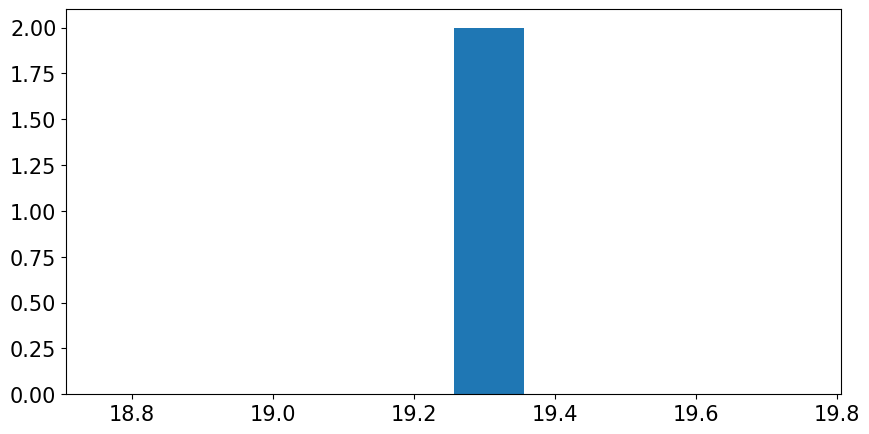

['SNAD112']


In [11]:
df = pd.read_csv('id_result_z_v14.csv')
df = df[(abs(df['z']-0.035)<0.001) | (abs(df['z']-0.65)<0.001)| (abs(df['z']-0.025)<0.001)| (abs(df['z']-0.45)<0.001) 
        | (abs(df['z']-0.015)<0.001) | (abs(df['z']-0.30)<0.001)]
#[0.035,0.65]
#[0.025,0.45] 
#[0.015,0.30] 
print(df)
fig, ax = plt.subplots(1, 1, figsize=(10,5)) 
ax.hist(df['max_mag'])
plt.show()
print(df['name'].unique())

In [12]:
df = pd.DataFrame(columns=['name', 'model', 'error', 'text'])
df.to_csv('id_exception_v24.csv', mode='a', index= False)
df = pd.DataFrame(columns=['name', 'model', 'M', 'mse', 'z',
                    't0', 'amplitude', 'mwebv','mwr_v', 'max_mag'])
df.to_csv('id_result_z_v15.csv', mode='a', index= False)